In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## DATASET PREPARATION

In [3]:
path='/content/drive/MyDrive/ENDB2/SESSION-07/data/'
data_path='/content/drive/MyDrive/ENDB2/SESSION-07/data/stanfordSentimentTreebank/stanfordSentimentTreebank/'


In [4]:
import nltk 
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords, wordnet
 
import random


import os, pickle

In [6]:
sentiment_labels = pd.read_csv(os.path.join(data_path, "sentiment_labels.txt"), names=['phrase_ids', 'sentiment_values'], sep="|", header=0)

In [7]:
sentiment_labels.head()

,phrase_ids,sentiment_values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [8]:
def discretize_label(label):
    if label <= 0.2: return 0
    if label <= 0.4: return 1
    if label <= 0.6: return 2
    if label <= 0.8: return 3
    return 4

In [9]:

sentiment_labels['sentiment_values'] = sentiment_labels['sentiment_values'].apply(discretize_label)

In [10]:
sentence_ids = pd.read_csv(os.path.join(data_path, "datasetSentences.txt"), sep="\t")

In [11]:
sentence_ids.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [12]:
dictionary = pd.read_csv(os.path.join(data_path, "dictionary.txt"), sep="|", names=['phrase', 'phrase_ids'])

In [13]:
dictionary.head()

,phrase,phrase_ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [14]:
train_test_split = pd.read_csv(os.path.join(data_path, "datasetSplit.txt"))


In [15]:
train_test_split.head()

,sentence_index,splitset_label
0,1,1
1,2,1
2,3,2
3,4,2
4,5,2


In [16]:
sentence_phrase_merge = pd.merge(sentence_ids, dictionary, left_on='sentence', right_on='phrase')

In [17]:
sentence_phrase_merge.head()

,sentence_index,sentence,phrase,phrase_ids
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999


In [18]:
sentence_phrase_split = pd.merge(sentence_phrase_merge, train_test_split, on='sentence_index')
dataset = pd.merge(sentence_phrase_split, sentiment_labels, on='phrase_ids')

In [19]:
dataset.head()

,sentence_index,sentence,phrase,phrase_ids,splitset_label,sentiment_values
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,1,3
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,1,4
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2,2
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,2,3
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,2,4


In [20]:
len(dataset)

11286

In [21]:
train_final=dataset[['sentence','sentiment_values']][dataset.splitset_label==1]
test=dataset[['sentence','sentiment_values']][dataset.splitset_label==2]


In [22]:
len(train_final),len(test)

(8117, 2125)

In [23]:
2125/11286, 8117/11826

(0.1882863724968988, 0.6863690174192457)

In [24]:
# By default data is split into train 68 % test 18 % dev 14 %

# 2 things can be done a. take whole dataset take 70 % sample as train 30 % as test 
                       # b . leave traing data as it is merge test and dev 

In [25]:
# we will go with first approach 

In [26]:
# filter out necessary column 

In [27]:
dataset = dataset[['sentence','sentiment_values']]

In [28]:
dataset=dataset.rename(columns={"sentiment_values": "label"})

In [29]:
train_final= dataset.sample(frac=0.70).reset_index(drop=True)
test= dataset.sample(frac=0.30).reset_index(drop=True)

In [30]:
train_final.head()

,sentence,label
0,"This is a great subject for a movie , but Holl...",1
1,"The complex , politically charged tapestry of ...",3
2,A suffocating rape-payback horror show that hi...,3
3,Not that any of us should be complaining when ...,1
4,"The actors are appealing , but Elysian Fields ...",2


In [31]:
test.head()

,sentence,label
0,"For its 100 minutes running time , you 'll wai...",0
1,A few energetic stunt sequences briefly enlive...,2
2,Remember back when thrillers actually thrilled ?,1
3,"Or , you can do something fun tonight .",2
4,"All leather pants & augmented boobs , Hawn is ...",3


In [32]:
print("Train Percentage",round(len(train_final)/len(dataset)*100,2))
print("Test Percentage",round(len(test)/len(dataset)*100,2))

Train Percentage 70.0
Test Percentage 30.0


## PREPROCESSING TOKENIZATION EMBEDDING

In [33]:
#basic text cleaning for train only 

In [34]:
def  clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s\n\t\-]","",str(text))
    text = text.replace("-", " ") #replace hyphens with spaces
    text = text.replace("\t", " ")
    text = text.replace("\n", " ")
    text = text.replace("\'", "")
    text = text.replace("\`", "")
    text = text.replace("\,", "")
    text = text.replace("\.", "")
    #replace single charcter words 
    text = re.sub(r"\b[a-zA-Z0-9]\b", "", str(text))
    text =  re.sub(r"\d+", "", str(text))
    #replace multiple space with single space 
    text = re.sub(r"\s+", " ", str(text))
    return text 

In [35]:
clean_text("Leigh 's film is full of memorable performance")

'leigh film is full of memorable performance'

In [36]:
train_final['sentence'] = train_final['sentence'].apply(clean_text)

In [37]:
#as sentence length were very small lets check if we have introduced any blank line 

In [38]:
train_final1=train_final.copy()
def return_word_count(sent):
  l=sent.split(" ")
  return len(l)

train_final1['sen_len']=train_final1['sentence'].apply(return_word_count)

In [39]:
len(train_final1[(train_final1.sen_len==0)])

0

In [40]:
#plot value count of label

[Text(0.5, 0, 'Labels')]

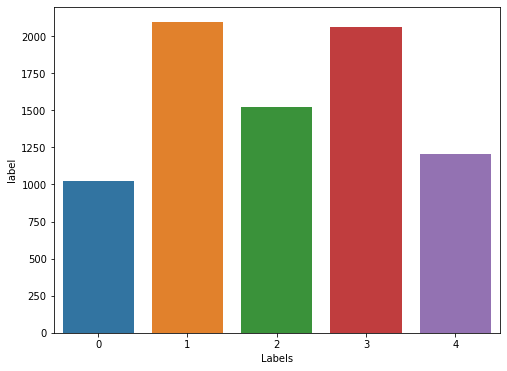

In [41]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x=train_final['label'].unique(), y=train_final['label'].value_counts())
ax.set(xlabel = 'Labels')

In [42]:
#DEFINE FIELD 

In [43]:
Text = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
#Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)
Label = torchtext.legacy.data.LabelField(dtype = torch.int64)

In [44]:
#Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:
#Text and Label ->Field 
#sentence and label ->column of dataframe 

In [45]:
datafields = [('sentence', Text),('label', Label)]

In [46]:
# lets convert from pandas to list to torchtext

In [47]:
train_example = [torchtext.legacy.data.Example.fromlist([train_final.sentence[i],train_final.label[i]], datafields) for i in range(train_final.shape[0])] 
test_example = [torchtext.legacy.data.Example.fromlist([test.sentence[i],test.label[i]], datafields) for i in range(test.shape[0])]

In [48]:
#CREATE DATASET

In [49]:
train_data = torchtext.legacy.data.Dataset(train_example, datafields)
valid_data = torchtext.legacy.data.Dataset(test_example, datafields)



In [50]:
(len(train_data), len(valid_data))

(7900, 3386)

In [51]:
#some example

In [52]:
print(vars(train_data[5]))

{'sentence': [' ', 'antwone', 'fisher', 'is', 'an', 'earnest', 'by', 'the', 'numbers', 'effort', 'by', 'washington'], 'label': 3}


In [53]:
print(vars(valid_data[5]))

{'sentence': ['One', 'Hour', 'Photo', 'may', 'seem', 'disappointing', 'in', 'its', 'generalities', ',', 'but', 'it', "'s", 'the', 'little', 'nuances', 'that', 'perhaps', 'had', 'to', 'escape', 'from', 'director', 'Mark', 'Romanek', "'s", 'self', '-', 'conscious', 'scrutiny', 'to', 'happen', ',', 'that', 'finally', 'get', 'under', 'your', 'skin', '.'], 'label': 1}


In [54]:
# lets build vocab 

In [55]:
Text.build_vocab(train_data,  
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

Label.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
 99%|█████████▉| 397195/400000 [00:14<00:00, 28638.88it/s]

In [56]:
Text.vocab.vectors

tensor([[ 1.0728,  0.7212, -1.4292,  ...,  0.6976, -1.0489,  0.3594],
        [-0.7708,  0.1493,  1.4517,  ..., -0.1072,  0.3857, -0.4291],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560],
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842],
        [-0.9079,  0.4196, -1.0338,  ...,  1.2189,  1.0791, -0.4016]])

In [57]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  14429
Size of label vocab :  5
Top 10 words appreared repeatedly : [('the', 6683), ('and', 4084), ('of', 3981), ('to', 2802), ('is', 2344), ('it', 2308), ('in', 1794), ('that', 1771), (' ', 1209), ('as', 1207)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


In [58]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                                                            (train_data, valid_data),
                                                                            batch_size = BATCH_SIZE,
                                                                            sort_key = lambda x: len(x.sentence),
                                                                            sort_within_batch= True, 
                                                                            device = device,
                                                                            shuffle=True)

In [59]:
print('Train')
for batch in train_iterator:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nValid:')
for batch in test_iterator:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

Train
Text matrix size: torch.Size([128, 23])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([128, 6])
Target vector size: torch.Size([128])


In [60]:
#save tokenizer 

In [61]:
# SAVE TOKENIZER 
import os, pickle
with open(path+'tokenizer_SST.pkl', 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

## DEFINING OUR MODEL 

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying sentences.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming sentences) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (0,1,2,3,4).

In [62]:
#BUILD MODEL

In [63]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        # Constructor
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        # activation function
        self.act = nn.Softmax() #\ F.log_softmax(outp)

    def forward(self, text, text_lengths):
        # text = [batch size,sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True) # unpad

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # packed_output shape = (batch, seq_len, num_directions * hidden_size)
        # hidden shape  = (num_layers * num_directions, batch, hidden_size)

        # concat the final forward and backward hidden state
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # output, output_lengths = pad_packed_sequence(packed_output)  # pad the sequence to the max length in the batch

        rel = self.relu(cat)
        dense1 = self.fc1(rel)

        drop = self.dropout(dense1)
        preds = self.fc2(drop)

        # Final activation function
        # preds = self.act(preds)
        # preds = preds.argmax(dim=1).unsqueeze(0)
        return preds

In [64]:
#Hyper meter

In [65]:
# Define hyperparameters
size_of_vocab = len(Text.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = len(Label.vocab)
num_layers = 2
dropout = 0.2
PAD_IDX = Text.vocab.stoi[Text.pad_token]

hidden_dim2 = 128
bi_directional = True

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, hidden_dim2, num_output_nodes, num_layers, bi_directional, dropout = dropout, pad_index=PAD_IDX)

In [66]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(14429, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softmax(dim=None)
)
The model has 3,819,353 trainable parameters


In [67]:
pretrained_embeddings = Text.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[ 1.0728,  0.7212, -1.4292,  ...,  0.6976, -1.0489,  0.3594],
        [-0.7708,  0.1493,  1.4517,  ..., -0.1072,  0.3857, -0.4291],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560],
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842],
        [-0.9079,  0.4196, -1.0338,  ...,  1.2189,  1.0791, -0.4016]])

In [68]:

UNK_IDX = Text.vocab.stoi[Text.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

In [69]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


# # define metric
# def binary_accuracy(preds, y):
#     #round predictions to the closest integer
#     _, predictions = torch.max(preds, 1)
    
#     correct = (predictions == y).float() 
#     acc = correct.sum() / len(correct)
#     return acc


# define metric
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [70]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        # acc = binary_accuracy(predictions, batch.label)   

        # compute the categorical accuracy
        acc = categorical_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            # compute the binary accuracy
            # acc = binary_accuracy(predictions, batch.label)   

            # compute the categorical accuracy
            acc = categorical_accuracy(predictions, batch.label)  
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [71]:
# load train and test iteraror


In [72]:
N_EPOCHS = 50
best_valid_loss = float('inf')

train_loss_epoch=[]
valid_loss_epoch=[]
train_acc_epoch=[]
valid_acc_epoch=[]

for epoch in range(N_EPOCHS):
    print("epoch :---->",epoch)
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path+'saved_weights_SST.pt')

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)
    train_acc_epoch.append(train_acc)
    valid_acc_epoch.append(valid_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

epoch :----> 0


 99%|█████████▉| 397195/400000 [00:30<00:00, 28638.88it/s]

	Train Loss: 1.579 | Train Acc: 25.74%
	 Val. Loss: 1.570 |  Val. Acc: 27.16% 

epoch :----> 1
	Train Loss: 1.546 | Train Acc: 30.57%
	 Val. Loss: 1.495 |  Val. Acc: 34.91% 

epoch :----> 2
	Train Loss: 1.452 | Train Acc: 35.56%
	 Val. Loss: 1.428 |  Val. Acc: 38.18% 

epoch :----> 3
	Train Loss: 1.400 | Train Acc: 38.57%
	 Val. Loss: 1.391 |  Val. Acc: 40.28% 

epoch :----> 4
	Train Loss: 1.356 | Train Acc: 40.65%
	 Val. Loss: 1.359 |  Val. Acc: 41.56% 

epoch :----> 5
	Train Loss: 1.324 | Train Acc: 41.84%
	 Val. Loss: 1.336 |  Val. Acc: 42.17% 

epoch :----> 6
	Train Loss: 1.299 | Train Acc: 42.84%
	 Val. Loss: 1.325 |  Val. Acc: 42.16% 

epoch :----> 7
	Train Loss: 1.274 | Train Acc: 43.54%
	 Val. Loss: 1.303 |  Val. Acc: 43.40% 

epoch :----> 8
	Train Loss: 1.263 | Train Acc: 45.03%
	 Val. Loss: 1.312 |  Val. Acc: 43.48% 

epoch :----> 9
	Train Loss: 1.241 | Train Acc: 45.20%
	 Val. Loss: 1.294 |  Val. Acc: 43.93% 

epoch :----> 10
	Train Loss: 1.204 | Train Acc: 47.12%
	 Val. Los

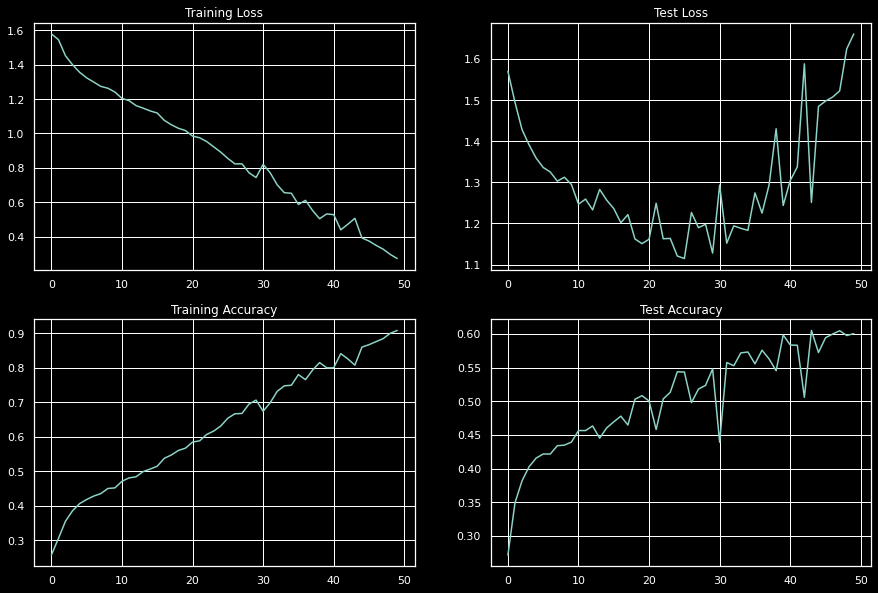

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_epoch)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(valid_loss_epoch)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_acc_epoch)
axs[1, 0].set_title("Training Accuracy")
axs[1, 1].plot(valid_acc_epoch)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [74]:
model_path=path+'/saved_weights_SST.pt'
model.load_state_dict(torch.load(model_path));
model.eval();
tokenizer_file = open(path+'./tokenizer_SST.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)



import spacy
nlp = spacy.load('en')

def classify_text(tweet):
    
    categories = {0: "0", 1:"1", 2:"2", 3:"3", 4:"4"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    #print(prediction)

    #_, pred = torch.max(prediction, 1) 
    pred = prediction.argmax(1, keepdim = True)
    
    return categories[pred.item()]

In [75]:
#for individual prediction 
classify_text("The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal good bad worst   ")

'1'

In [76]:
test.head()

,sentence,label
0,"For its 100 minutes running time , you 'll wai...",0
1,A few energetic stunt sequences briefly enlive...,2
2,Remember back when thrillers actually thrilled ?,1
3,"Or , you can do something fun tonight .",2
4,"All leather pants & augmented boobs , Hawn is ...",3


In [77]:
test1=test
test1['pred_label']=test1.sentence.apply(classify_text)

In [78]:
test1.head()

,sentence,label,pred_label
0,"For its 100 minutes running time , you 'll wai...",0,1
1,A few energetic stunt sequences briefly enlive...,2,0
2,Remember back when thrillers actually thrilled ?,1,2
3,"Or , you can do something fun tonight .",2,2
4,"All leather pants & augmented boobs , Hawn is ...",3,0


In [79]:
# LETS CROSS TAB 
pd.crosstab(test1['label'],test1['pred_label'])

pred_label,0,1,2,3,4
label,,,,,
0,12,198,68,2,149
1,44,536,227,0,100
2,104,149,371,4,24
3,576,51,227,49,7
4,230,6,47,205,0


In [80]:
# PLOT CONFUSION MATRIX 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, 
                          classes=['Very Negative','Negative','Neutral','Positive','Very Positive'],#[1, 2, 3, 4, 5],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff23cd1a750>)

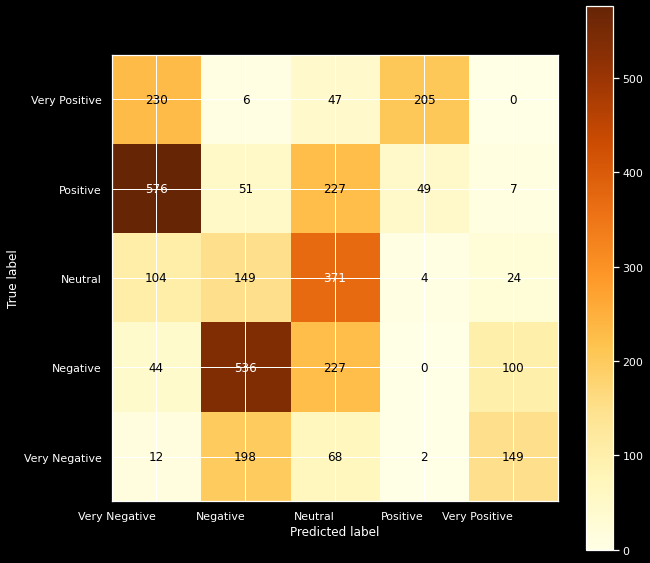

In [81]:
plt.rcParams["figure.figsize"] = (10,10)

plot_confusion_matrix(test1['label'].values.tolist(), test1['pred_label'].astype(int).values.tolist())

In [82]:
test1.to_csv(path+"result_test.csv")

In [83]:
test1=pd.read_csv(path+"result_test.csv")

In [84]:
test_correct =test1[(test1.label == test1.pred_label ) ]
test_incorrect =test1[(test1.label != test1.pred_label ) ]                  

In [85]:
#LETS PRINT OUT 10 CORRECT PREDICTION 

In [86]:
SentimentClass = {0:'Very Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Very Positive'}
correctly_classified_texts=test_correct[:10]
print("*"*40)
print("***** Correctly Classified Text: *******")
print("*"*40)
for i, (index, row) in enumerate(correctly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['sentence']}")
  print(f"   Target Sentiment: {SentimentClass[row['label']]}")
  print(f"   Predicted Sentiment: {SentimentClass[row['pred_label']]}")
  print()

****************************************
***** Correctly Classified Text: *******
****************************************
1) Text: Or , you can do something fun tonight .
   Target Sentiment: Neutral
   Predicted Sentiment: Neutral

2) Text: One Hour Photo may seem disappointing in its generalities , but it 's the little nuances that perhaps had to escape from director Mark Romanek 's self-conscious scrutiny to happen , that finally get under your skin .
   Target Sentiment: Negative
   Predicted Sentiment: Negative

3) Text: The big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing .
   Target Sentiment: Negative
   Predicted Sentiment: Negative

4) Text: Befuddled in its characterizations as it begins to seem as long as the two year affair which is its subject
   Target Sentiment: Negative
   Predicted Sentiment: Negative

5) Text: Some people want the ol' ball-and-chain and then there are those who just want th

In [87]:
#LETS PRINT OUT 10 INCORRECT PREDICTION 

In [88]:
SentimentClass = {0:'Very Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Very Positive'}
incorrectly_classified_texts=test_incorrect[:10]
print("="*40)
print("***** incorrectly Classified Text: *******")
print("="*40)
for i, (index, row) in enumerate(incorrectly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['sentence']}")
  print(f"   Target Sentiment: {SentimentClass[row['label']]}")
  print(f"   Predicted Sentiment: {SentimentClass[row['pred_label']]}")
  print()

***** incorrectly Classified Text: *******
1) Text: For its 100 minutes running time , you 'll wait in vain for a movie to happen .
   Target Sentiment: Very Negative
   Predicted Sentiment: Negative

2) Text: A few energetic stunt sequences briefly enliven the film , but the wheezing terrorist subplot has n't the stamina for the 100-minute running time , and the protagonists ' bohemian boorishness mars the spirit of good clean fun .
   Target Sentiment: Neutral
   Predicted Sentiment: Very Negative

3) Text: Remember back when thrillers actually thrilled ?
   Target Sentiment: Negative
   Predicted Sentiment: Neutral

4) Text: All leather pants & augmented boobs , Hawn is hilarious as she tries to resuscitate the fun-loving libertine lost somewhere inside the conservative , handbag-clutching Sarandon .
   Target Sentiment: Positive
   Predicted Sentiment: Very Negative

5) Text: Do you say `` hi '' to your lover when you wake up in the morning ?
   Target Sentiment: Neutral
   Predict